# Código Proyecto Final Simulación Estocástica: The College Application Problem.



Cristóbal Godoy y Fraick Reyes.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math as math
import warnings
import time
warnings.filterwarnings("ignore")

In [ ]:
#generator: int -> int array array array
#tenemos previamente un array de indices de universidades de largo m, esta funcion
#crea parametros (aleatorios) adecuados al problema , se explicitan abajo.
def generator(m): #m=cantidad de universidades
  assert type(m)==int or type(m)==np.int64
  t = np.random.exponential(scale=10,size=m)
  t = np.ceil(t)
  t=t.astype(int)
  Q = np.random.uniform(size=m)
  f = np.array([1/(t[i]+10*Q[i]) for i in range(m)],dtype=np.float128)
  g = np.array([np.random.randint(5,11) for i in range(m)])
  H = math.floor(np.sum(g)/2)
  indices_ordenados = np.argsort(t) #indexo todo en orden ascendente por valores de t
  t=t[indices_ordenados]
  g=g[indices_ordenados]
  f=f[indices_ordenados]
  return H,t,g,f #H: presupuesto, t:  utilidad de universidades, g: costos, f: prob de exito de postulacion

#v: array, array, array -> num
#funcion de utilidad que dada universidades X y parametros t,f otorga la utilidad v asociada del problema
#las universidades estan en el sentido de indicatriz, por ejemplo X=[1,0,0,1,1,1,0]
def v(X,t,f): #X: universidades, t:  utilidad de universidades, f: prob de exito de postulacion
  assert len(X) == len(t) == len(f), "Los arrays no tienen el mismo tamaño"
  p=0
  n=len(t)
  for j in range(n):
    if X[j]==1:
      h=f[j]*t[j]
      for i in range(j+1,n):
        if X[i]==1:
          h*=(1-f[i])
      p+=h
  return p

#v: array, array, array num -> num
#Variación de la funcion v a optimizar que tiene en cuenta la varianza
def v_b(X,t,f,b): #b: valor de penalizacion por varianza >=0
  n=len(t)
  tau = np.zeros(n)
  for i in range(n):
    tau[i] = t[i]-b*(t[i])**2
  val= v(X,tau,f)+b*(v(X,t,f))**2
  return val

In [ ]:
#dp: [num,array,array,array] -> array, num
#Algoritmo Dynamic programing para resolver el problema, recibe H,t,g,f,
#devuelve el vector de universidades y valor optimo
#Asumimos g_j's y H naturales
def dp(parametros):
  H,t,g,f=parametros #H:Presupuesto, t:Utilidad de universidades, g:Costos, f:Prob de exito de postulacion
  m=len(t)
  V = np.zeros((m+1,H+1)) #matriz que definimos recursivamente (ver paper pg 18)
  for j in range(1,m+1):
    for h in range(1,H+1):
      if h-g[j-1]<0: #en este queda un indice<0 y por convencion V(%)=-inf
        V[j,h] = V[j-1,h]
      else:
        V[j,h] = max(V[j-1,h], (1-f[j-1])*V[j-1,h-g[j-1]]+f[j-1]*t[j-1])
  h = H
  X = np.zeros(m)
  xs=np.zeros(m)
  for j in range(m,0,-1):
    if V[j-1,h]<V[j,h]:
      X[j-1] = 1
      h-=g[j-1]
  return X,V[m,H]

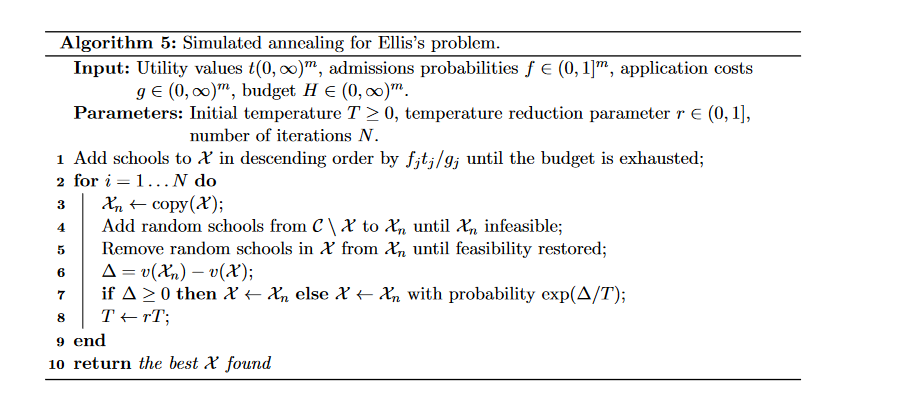

In [ ]:
#transicion: array int array int -> array int
#funcion que transiciona entre un estado X a uno nuevo vecino X_new, recibe parametros de factibilidad
#H:Presupuesto, g:Costos y g_suma que corresponde a cuanto del presupuesto usa X
#retorna un vecino X_new y que tanto presupuesto usa g_suma_new

def transicion(X,H,g,g_suma): #encontrara un vecino aleatorio al que transicionar
  n=len(X)
  X_new, g_suma_new=X.copy(), g_suma
  p=np.array([i for i in range(n) if X_new[i]==1]) #indices de a cuales estamos postulando
  no_p = np.setdiff1d(np.arange(n), p) #indices de a cuales no estamos postulando
  np.random.shuffle(p)  #desordenamos
  np.random.shuffle(no_p)
  while len(no_p)>0 and len(p)>0 and len(p)>0: #intercambiamos dos universidades en X_new aleatoriamente
    entra=no_p[-1] #entra una a la cual no estabamos postulando
    sale=p[0] #sale una a la cual estabamos postulando
    X_new[entra]=1
    X_new[sale]=0
    no_p = np.delete(no_p, -1)
    p = np.delete(p, 0)
    g_suma_new= g_suma_new +g[entra]-g[sale] #actualizamos cuando presupuesto usamos
    if g_suma_new<=H: #cuando seamos factibles estamos listos
      break
  p=np.array([i for i in range(n) if X_new[i]==1]) #indices de a cuales estamos postulando
  np.random.shuffle(p)  #desordenamos
  while g_suma_new>H: #si aun somos infactibles sacamos universidades de X_new
    k=p[0]
    X_new[k]=0
    p = np.delete(p, 0)
    g_suma_new-=g[k]
  return X_new,g_suma_new

#budget: int, [int,array,array,array]-> array int array
#recibe cantidad de iteraciones N, parametros del college problem y constantes de como cambia
#la temperatura:Tn=tp*(r)**n, por ultimo b es el caso de que funcion de utilidad usemos
#devuelve el vector de universidades (0 o 1 dependiendo de si se postula o no), el optimo
#y un vector xs para graficar

def budget(N,parametros,tp,r,b=-1):#N:iteraciones,parametros:datos,tp:temperatura,r:factor de tp, b=caso
  H,t,g,f=parametros #H: presupuesto, t:  utilidad de universidades, g: costos, f: prob de exito de postulacion
  funcion = lambda x: v(x,t,f) if b ==-1 else v_b(x,t,f,b) #b!=1 para caso con varianza
  n=len(t) #cantidad de universidades
  hola=f*t/g
  max_indices = np.argsort(hola)[::-1] #ordena los indices que sean mayores en hola (en el 0 esta el mas grande)
  X=np.zeros(n) #caso inicial
  g_suma=0
  for indice in max_indices: #agregamos de forma descendente (c/r a hola) mientras no seamos infactibles
    if g[indice]+g_suma<=H:
      X[indice]=1
      g_suma+=g[indice]
    else: break
  xs=np.zeros(N) #para graficar
  v_X=funcion(X)
  X_best,v_best=X.copy(),v_X #guardamos el mejor hasta la iteracion i-esima
  for i in range(N-1):  #recursion
    xs[i]=v_X #para graficar
    g_prev=g_suma
    #print(i)
    Xnew,g_suma_new=transicion(X,H,g,g_suma) #obtenemos un vecino
    v_Xn=funcion(Xnew)
    d=v_Xn-v_X #delta
    if d>=0: #d>0 siempre se transiciona
      X,v_X=Xnew.copy(),v_Xn
      g_suma=g_suma_new
      if v_X>v_best:
        X_best,v_best=X.copy(),v_X #actualizamos el mejor
    else:  #si d<0
      if np.random.uniform()<=np.exp(d/tp): #transicionamos con probabilidad exp(d/t)
        X,v_X=Xnew.copy(),v_Xn
        g_suma=g_suma_new
      else: #si no transicionamos no actualizamos las variables
        g_suma=g_prev
    tp*=r
  xs[N-1]=v_X #para graficar
  return X_best, v_best,xs

#budget_eps: [int,array,array,array] num num num num -> array
#funciona analogo a la funcion de arriba, pero en este caso se recibe el optimo (verdadero) y un error.
#El algoritmo itera hasta que encuentre una solucion cercana al optimo y la retorna.
#se usara para estudiar que algoritmo converge mas rapido a la solucion (salvo error chico)
def budget_eps(datos,eps,opt,tp=1/4,r=1/16):#parametros:datos, tp:temperatura, r:factor de tp, eps:error, opt: optimo real
  H,t,g,f=datos #H: presupuesto, t:  utilidad de universidades, g: costos, f: prob de exito de postulacion
  n=len(t) #cantidad de universidades
  hola=f*t/g
  max_indices = np.argsort(hola)[::-1] #ordena los indices que sean mayores en hola (en el 0 esta el mas grande)
  X=np.zeros(n) #caso inicial
  g_suma=0
  for indice in max_indices: #agregamos de forma descendente (c/r a hola) mientras no seamos infactibles
    if g[indice]+g_suma<=H:
      X[indice]=1
      g_suma+=g[indice]
    else: break
  v_X=v(X,t,f)
  X_best,v_best=X.copy(),v_X #guardamos el mejor hasta la iteracion i-esima
  while True:
    if abs(v_best-opt)<=eps or v_best>opt: break
    g_prev=g_suma
    #print(i)
    Xnew,g_suma_new=transicion(X,H,g,g_suma) #obtenemos un vecino
    v_Xn=v(Xnew,t,f)
    d=v_Xn-v_X #delta
    if d>=0: #d>0 siempre se transiciona
      X,v_X=Xnew.copy(),v_Xn
      g_suma=g_suma_new
      if v_X>v_best:
        X_best,v_best=X.copy(),v_X #actualizamos el mejor
    else:  #si d<0
      if np.random.uniform()<=np.exp(d/tp): #transicionamos con probabilidad exp(d/t)
        X,v_X=Xnew.copy(),v_Xn
        g_suma=g_suma_new
      else: #si no transicionamos no actualizamos las variables
        g_suma=g_prev
    tp*=r

  return X_best, v_best


In [ ]:
#graficotodo: str int int array/int array/int bool -> None
#recibe un caso:"r","t","b", por ejemplo "r" indica que se recibe un vector R y una cte T
#y se grafican curvas para cada r en R; "t" y "b" funcionan de forma similar.
#el parametro texto es un bool para imprimir los vectores optimos en el caso "b"
def graficotodo(datos,caso,N,T,R,texto): #datos: parametros, N:iteraciones, T=temperatura, R=factor de escala, texto=imprimir detalles
  m=len(datos[1])
  assert caso=="b" or caso=="r" or caso =="t"
  plt.figure(figsize=(6,4))
  if caso == "r": #aca variamos el R=[r0,r1,r2,...,rk]
    R=np.sort(R)
    assert isinstance(T, (int, float)) and type(R)==np.ndarray
    for i,r in enumerate(R):
      c=budget(N,datos,T,r)[2]
      plt.plot(range(N),c, label = "r =" + str(round(r,3)))
    plt.title("Simulated Annealing variando el factor de escala R\n"+str(m)+" universidades, T="+str(T),pad=10)
  elif caso=="t": #aca variamos el T=[t0,t1,t2,...,tk]
    T=np.sort(T)
    assert isinstance(R, (int, float)) and type(T)==np.ndarray
    for i,t in enumerate(T):
      c=budget(N,datos,t,R)[2]
      plt.plot(range(N),c, label = "t =" + str(t),linestyle="-.")
    plt.title("Simulated Annealing variando la temperatura T\n"+str(m)+" universidades, R="+str(R),pad=10)
  elif caso == "b": #aca variamos el b
    if texto:
      print("==========================================================================")
      print("f=",np.round(datos[3],decimals=3))
    x,opt,xs=budget(N,datos,T,R)
    if texto: print("b= 0: ",x)
    plt.plot(range(N),xs,label="b =0",color="black")
    B=[0.01,0.05,0.1,0.5,0.8,1,2,5] #predeterminamos casos representativos
    for b in B:
      x,opt_v,xs=budget(N,datos,T,R,b)
      plt.plot(range(N),xs, label = "b =" + str(b),linestyle="-.")
      if texto: print("b=",b,":",x)
      plt.ylim(-10,opt+1)
    plt.title("Evolución del algoritmo con varianza\n"+str(m)+" universidades, T="+str(T)+", R="+str(R),pad=10)
    if texto: print("==========================================================================")
  plt.xlabel("Iteración n-ésima")
  plt.ylabel("Óptimo n-ésimo")
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()


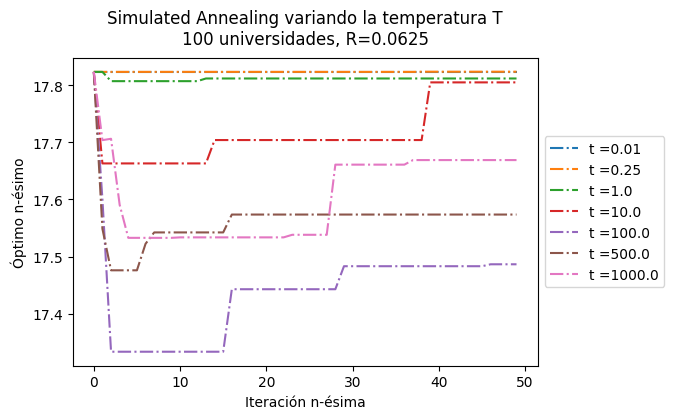

In [ ]:
m=100 #cantidad de universidades
parametros=generator(m) #fijamos los datos
T=np.array([1/4,0.01,1,10,100,500,1000])
graficotodo(parametros,"t",50,T,1/16,False) #N=50 iteraciones para ver el comportamiento a corto plazo

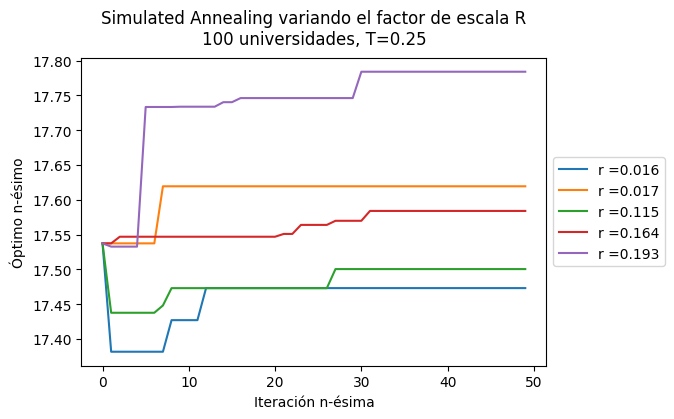

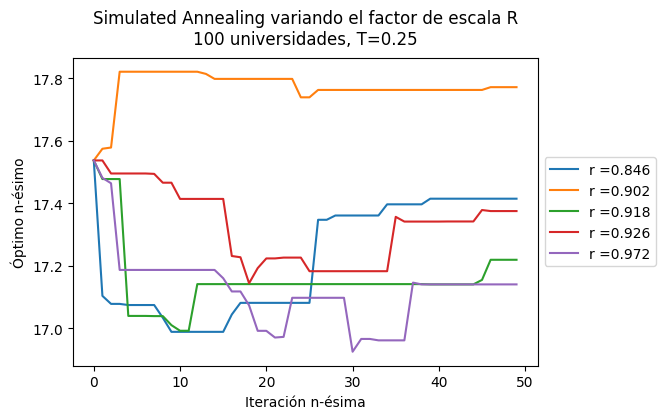

In [ ]:
m=100 #cantidad de universidades
parametros=generator(m) #fijamos los datos
R=np.random.uniform(0,0.2,size=5)
graficotodo(parametros,"r",50,1/4,R,False)
R=np.random.uniform(0.8,1,size=5)
graficotodo(parametros,"r",50,1/4,R,False) #N=50 iteraciones para ver el comportamiento a corto plazo

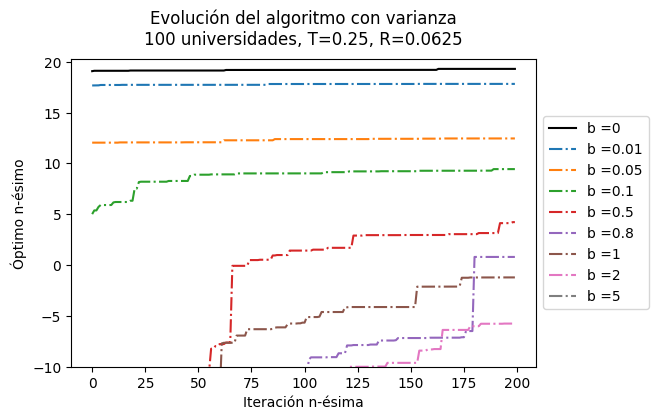

In [ ]:
m=100 #cantidad de universidades
parametros=generator(m) #fijamos los datos
graficotodo(parametros,"b",200,1/4,1/16,False)#cambiar a True para imprimir X_opts y f para analizar la penalizacion b

In [ ]:
#Tgrafico: array array num num -> None
#grafica la razon de optimalidad entre dynamic programming y simulated annealing (simulated/dynamic)
#para un vector de ciudades M y N iteraciones, se eligen tp y r por defecto
def Tgrafico(N,M,tp=1/4,r=1/16): #N:iteraciones, M:vector # de universidades, tp: temperatura, r:factor de tp
  dt=np.linspace(0,M[-1],10)
  y = np.full_like(dt, 1)
  plt.plot(dt,y,color="#C71585",linestyle="--")
  datos=np.zeros(len(M))
  j=0
  for i in M:
    parameter= generator(i)
    opt1=budget(N,parameter,tp,r)[1]
    opt2=dp(parameter)[1]
    #opt1=budget_eps(parametros,tp,r,opt2/10,opt2)[1]
    if opt2==0:
      if opt1==0: datos[j]=1
      else: datos[j]=0
    else: datos[j]=opt1/opt2
    j+=1
  plt.plot(M, datos,marker='o', linestyle='',color="purple",markersize=4)

  plt.ylim(0.97, 1.003)
  posiciones_marcas = [0.97, 0.98, 0.99, 1.0]
  etiquetas_marcas = [str(pos) for pos in posiciones_marcas]
  plt.yticks(posiciones_marcas, etiquetas_marcas)
  plt.title("Razon de optimalidad de Simulated Annealing\nN= "+str(N)+", T="+str(tp)+", R="+str(r),pad=10)
  plt.xlabel("m: Cantidad de universidades")
  plt.ylabel("Precision c/r a DP")


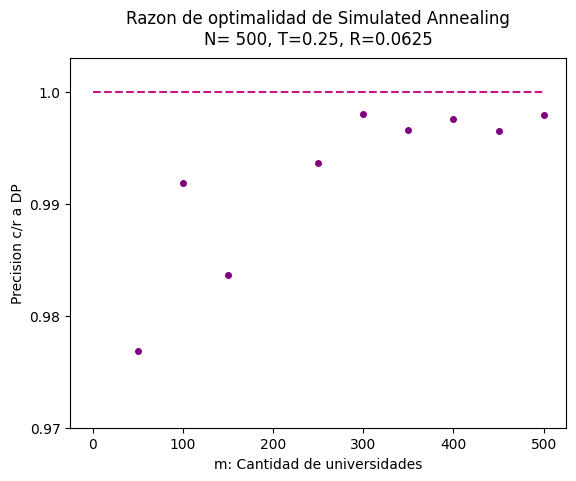

In [ ]:
N=500 #cantidad de iteraciones
M=np.arange(50, 500+50,50, dtype=int) #vector de ciudades
Tgrafico(N,M)

In [ ]:
#convergencia: [num,array,array,array] int num num num -> num num
#calcula cuanto se demora en promedio (k) los dos algoritmos en converger
#al optimo (salvo error)
def convergencia(datos,k,eps,tp=1/4,r=1/16):#datos: datos del problema (H,t,g,f), k: k-promedio, eps: error permitido
  t1=np.zeros(k) #simulated
  t2=np.zeros(k) #dynamic
  for j in range(k):
    ti=time.time()
    opt=dp(datos)[1]
    tf=time.time()
    t2[j]=tf-ti
    ti=time.time()
    budget_eps(datos,eps,opt)[1]
    tf=time.time()
    t1[j]=tf-ti
  return np.sum(t1)/k,np.sum(t2)/k

In [ ]:
#convergenciaGrafico: int num num num -> None
#grafica el ratio entre lo que se demoran los algoritmos simulated annealing/dynamic programming
#en funcion de la cantidad de universidades
def convergenciaGrafico(M,k,eps,t=1/4,r=1/16): #M: vector de # de universidades, k: k-promedio, eps: error, tp: temperatura, r: factor
  assert len(M)>=1
  l=len(M)
  t_simulated=np.zeros(l)
  t_dynamic=np.zeros(l)
  for i in range(l):
    #print(i)
    datos=generator(M[i])
    t_simulated[i],t_dynamic[i]=convergencia(datos,k,eps,t,r) #tp=1/4, r=1/16
  t_ratio= t_simulated/t_dynamic
  fig, axs = plt.subplots(1, 2, figsize=(12,6))
  axs[0].plot(M,t_ratio,marker='o', linestyle='-',color="#1457E5",markersize=5)
  axs[1].plot(M,t_ratio,marker='o', linestyle='-',color="#1457E5",markersize=5)
  axs[1].set_ylim(0,0.025)
  for i in [0,1]:
    axs[i].set_xlabel("m: Cantidad de universidades")
    axs[i].set_ylabel("Tiempo c/r a DP")
    axs[i].set_title("Comparacion de eficiencia entre algoritmos\nt="+str(t)+ ", r="+str(r)+", ε="+str(eps)+", k="+str(k),pad=10)
  plt.tight_layout()
  plt.show()
  return t_simulated,t_dynamic

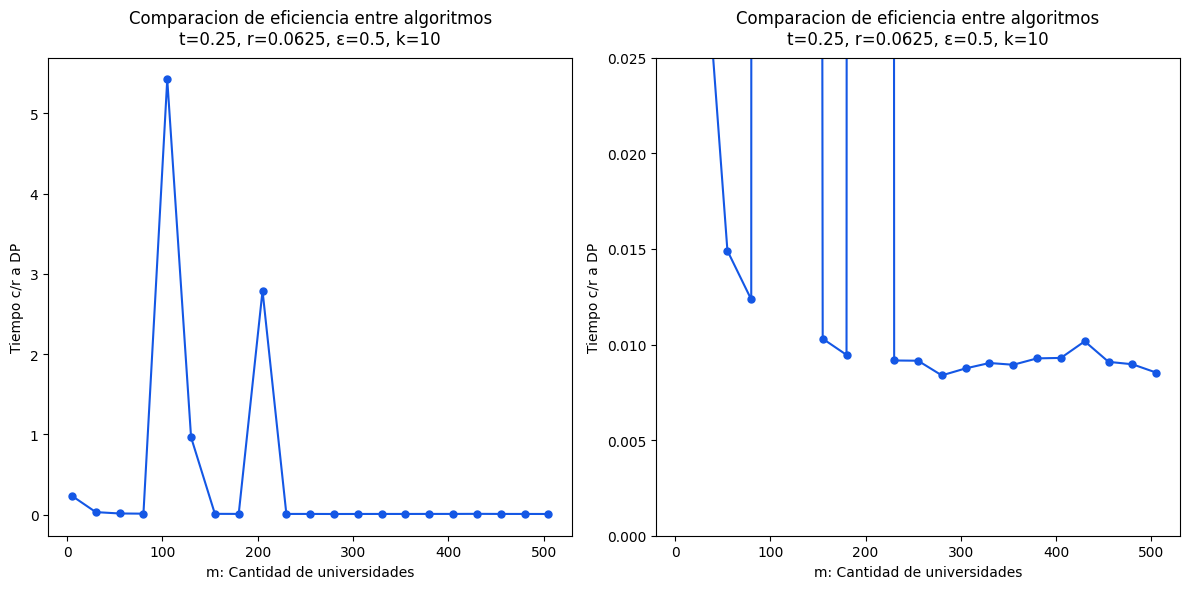

In [ ]:
M=np.arange(5, 500+30,25, dtype=int)
k,eps=10,0.5
a,b=convergenciaGrafico(M,k,eps)